# Det2stoc algorithm

1. **Data<sub>sim</sub>** `[previous_state, action, next_state, params]` is collected from MuJoCo with varying mass parameters in each episode
1. **Data<sub>real</sub>** `[previous_state, action, next_state]` is collected from the real robot (or some specific configuration of MuJoCo representing our desired "hidden" state)
1. A network **D** is trained on **Data<sub>sim</sub>** to match the output of MuJoCo `[next_state]` with inputs `[mass_param, previous_state, action]`
1. **D** is used as decoder to train a **CVAE** on **Data<sub>real</sub>** with inputs `[next_state]` conditioned on `[previous_state, action]`
1. **D** is again trained to output the next state on **Data<sub>sim</sub>**, except this time the `mass_param` is replaced by sampling latent variables from the encoder (how?) such that inputs become `[N(phi_mu, phi_sigma), previous_state, action]`
1. ?

In [1]:
import numpy as np
# np.set_printoptions(precision=4, suppress=False)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib import layers as tf_layers
from tensorflow_probability import distributions as tfp

from sklearn import preprocessing

sns.set(palette='husl')

seed = 4
np.random.seed(seed)
tf.set_random_seed(seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [2]:
n_trials = 50
n_epochs_cvae = 500
batch_size = 32

PREPROCESS = False

SIM = 0
print('batch size:', batch_size)

batch size: 32


In [3]:
model_name = 'windyslope'


filename = './data/obstacle/windyplane_5000_friction-mean0.2292-std0.0142_insidebox-mean0.1006-std0.0437_wind-mean-1.70-std0.0820.npz'
with open(filename, 'rb') as f:
    data = np.load(f)

with open('./data/obstacle/real_windyplane_1000_friction0.23_insidebox0.11_wind-1.7.npz', 'rb') as f:
    real_data = np.load(f)
        
if not SIM:
    data = real_data
    
#np.random.shuffle(data)

# Only use a max of 1000 samples of real data
#data = data[np.random.choice(data.shape[0], 1024)]

print(data.shape)

(100000, 4)


In [4]:
n_actions = 0
n_states = n_outputs = len(data[0][0])#
mixture_components = 1
n_params = len(data[0][-2])
n_conditions = n_states + n_actions
n_codings = 3
dim_hidden= [64]*3
norm = 'layer_norm'


print('n_states: ', n_states)
print('n_actions: ', n_actions)
print('n_params: ', n_params)

n_states:  18
n_actions:  0
n_params:  3


In [5]:
def scale_deltas(deltas):
    deltas[:,:3] *= 10

def extract(data, scaler):
    states = np.array([d[0][:n_states].ravel() for d in data], dtype=np.float32)
    next_states = np.array([d[1][:n_states] for d in data], dtype=np.float32)
    
    try:
        params = np.array([d[-1][:n_params] for d in data], dtype=np.float32)
    except:
        print('Did not find params array!')
        params = np.array([d[-2][:n_params] for d in data], dtype=np.float32)
        
    next_states = next_states - states
    scale_deltas(next_states)

    return states, next_states, params

state_scaler = None#preprocessing.StandardScaler()

states, next_states, params = extract(data, state_scaler)

print(np.min(params, axis=0))
print(np.max(params, axis=0))

#assert np.allclose(real_params.min(axis=0), real_params.max(axis=0), rtol=1e-1), 'min {} vs max {}'.format(real_params.min(axis=0), real_params.max(axis=0))

Did not find params array!
[ 0.18753086 -0.00261354 -1.8425846 ]
[ 0.26194265  0.2484537  -1.5740452 ]


In [6]:
n_trajs = 100

split = 100*n_trajs # n_trajs
train_trajs = n_trajs*100
states_train, states_test = states[:split], states[split:]
states_train, states_val = states_train[:train_trajs], states_train[train_trajs:]

next_states_train, next_states_test = next_states[:split], next_states[split:]
next_states_train, next_states_val = next_states_train[:train_trajs], next_states_train[train_trajs:]

params_train, params_test = params[:split], params[split:]
params_train, params_val = params_train[:train_trajs], params_train[train_trajs:]

if SIM:
    states_test, next_states_test, params_test = extract(real_data, state_scaler)

samples2plot = np.random.choice(len(states_test), 30)

print('Size of train: ', len(states_train))
print('Size of val: ', len(states_val))
print('Size of test: ', len(states_test))

Size of train:  10000
Size of val:  0
Size of test:  90000


In [7]:
n_batches = len(states_train) // batch_size

# Plot functions

In [8]:
def boxplot(x_data, y_data, base_color='#77CCBB', median_color='#FC7382', x_label='', y_label='', title=''):
    _, ax = plt.subplots(figsize=(16,8), facecolor='w')

    ax.boxplot(y_data,
               medianprops = {'color': median_color},
               boxprops = {'color': base_color},
               whiskerprops = {'color': base_color},
               capprops = {'color': base_color},
               showfliers=False)

    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    return ax

In [9]:
def get_results():

    x, y = states_test, next_states_test
    sess.run(init_test_op, {BATCH_SIZE: len(x)})

    logprob = cvae.log_prob(Y)
    logprob = tf.reduce_mean(logprob)
    results = sess.run(logprob, feed_dict={X: x, Y: y})
    #results /= len(x)
    print('Results with prior:', results)
    sess.run(init_op, {BATCH_SIZE: len(x)})

In [10]:
def sample_and_plot(samples, s, ns, state_idx=0, n_trials=50, plot_previous_state=False):
    n_samples = len(s)

    outputs = np.empty((n_samples, n_trials, n_outputs))

    for i in range(n_samples):
        states = np.tile(s[i], [n_trials, 1])
        out = sess.run(samples, feed_dict={X: states, BATCH_SIZE: len(states)})
        outputs[i] = out
    
    ax = boxplot(range(len(outputs)), outputs[:,:,state_idx].T, x_label='Sample#', y_label='State value', 
             title='Prediction estimates and actual values for state index: {}.'
             'The colored dots correspond to the true next state for a particular sample.'.format(state_idx))

    for i in range(n_samples):
        # Box plot always starts from 1
        x = i+1
        y = ns[i,state_idx]
        ax.plot(x, y, marker='o', label='true value')

    plt.show()

In [11]:
def sample_with_choice(choice, states=states_test, next_states=next_states_test, params=params_test, n_codings=n_codings):
    s = np.take(states, choice, axis=0)
    ns = np.take(next_states, choice, axis=0)
    p = np.take(params, choice, axis=0)
    return s, ns, p

# CVAE

In [12]:
def softplus_inverse(x):
    return tf.log(tf.expm1(x))

def normalize(inp, activation, reuse, scope, norm='None'):
    if norm == 'batch_norm':
        return tf_layers.batch_norm(inp, activation_fn=activation, reuse=reuse, scope=scope)
    elif norm == 'layer_norm':
        return tf_layers.layer_norm(inp, activation_fn=activation, reuse=reuse, scope=scope)
    elif norm == 'None':
        if activation is not None:
            return activation(inp)
        else:
            return inp

def encoder_weights(n_codings=n_codings, dim_hidden=dim_hidden, stddev=1e-2, scope='encoder_weights'):
    weights = {}
    with tf.variable_scope(scope):
        weights['w1'] = tf.Variable(tf.truncated_normal([n_conditions+n_outputs, dim_hidden[0]], stddev=stddev))
        weights['b1'] = tf.Variable(tf.zeros([dim_hidden[0]]))
        for i in range(1,len(dim_hidden)):
            weights['w'+str(i+1)] = tf.Variable(tf.truncated_normal([dim_hidden[i-1], dim_hidden[i]], stddev=stddev))
            weights['b'+str(i+1)] = tf.Variable(tf.zeros([dim_hidden[i]]))
        # Need mu and sigma, so n_codings*2
        weights['w'+str(len(dim_hidden)+1)] = tf.Variable(tf.truncated_normal([dim_hidden[-1], n_codings*2], stddev=stddev))
        weights['b'+str(len(dim_hidden)+1)] = tf.Variable(tf.zeros([n_codings*2]))
    return weights

def encoder_forward(X, Y, weights, dropout_rate, reuse=False, activation=tf.nn.relu, dim_hidden=dim_hidden, scope='encoder_weights'):
    with tf.variable_scope(scope):
        droppedY = tf.layers.dropout(Y, rate=dropout_rate)
        inp = tf.concat([X, droppedY], axis=1)
        hidden = normalize(tf.matmul(inp, weights['w1']) + weights['b1'], 
                           activation=activation, reuse=reuse, 
                           scope=('norm_' + str(0)))
        for i in range(1,len(dim_hidden)):
            hidden = normalize(tf.matmul(hidden, weights['w'+str(i+1)]) + weights['b'+str(i+1)], 
                               norm=norm, activation=activation, reuse=reuse, 
                               scope=('norm_' + str(i+1)))

        out = tf.matmul(hidden, weights['w'+str(len(dim_hidden)+1)]) + weights['b'+str(len(dim_hidden)+1)]
        mu = out[...,  :n_codings]
        logstd = tf.nn.softplus(out[..., n_codings:] + softplus_inverse(1.0))
        out = tfp.MultivariateNormalDiag(loc=mu, scale_diag=logstd)
        #out = tfp.Independent(out)
        return out
    
def make_prior(mixture_components, code_size, scope='prior_weights'):        
    with tf.variable_scope(scope):
#         loc = tf.get_variable(name="loc", shape=[code_size], trainable=True)
#         raw_scale_diag = tf.get_variable(name="raw_scale_diag", shape=[code_size], trainable=True)
#         components = tfp.MultivariateNormalDiag(loc=loc,
#                                                 scale_diag=raw_scale_diag)
#         return components
        out = tfp.MultivariateNormalDiag(loc=tf.zeros([code_size]), 
                                          scale_identity_multiplier=1.0)
        #out = tfp.Independent(out)
        return out

def decoder_weights(n_codings=n_codings, dim_hidden=dim_hidden,
                    scope='decoder_weights', stddev=1e-2):
    weights = {}
    with tf.variable_scope(scope):
        weights[scope+'w1'] = tf.Variable(tf.truncated_normal([n_codings+n_conditions, 
                                                               dim_hidden[0]], stddev=stddev))
        weights[scope+'b1'] = tf.Variable(tf.zeros([dim_hidden[0]]))
        for i in range(1,len(dim_hidden)):
            weights[scope+'w'+str(i+1)] = tf.Variable(tf.truncated_normal([dim_hidden[i-1], 
                                                                           dim_hidden[i]], stddev=stddev))
            weights[scope+'b'+str(i+1)] = tf.Variable(tf.zeros([dim_hidden[i]]))
        weights[scope+'w'+str(len(dim_hidden)+1)] = tf.Variable(tf.truncated_normal([dim_hidden[-1], n_outputs*2], stddev=stddev))
        weights[scope+'b'+str(len(dim_hidden)+1)] = tf.Variable(tf.zeros([n_outputs*2]))
    return weights

def decoder_forward(prior, condition, weights, reuse=False, activation=tf.nn.relu, 
                    dim_hidden=dim_hidden, scope='decoder_weights'):
    with tf.variable_scope(scope):
        inp = tf.concat([prior, condition], axis=-1)
        hidden = normalize(tf.matmul(inp, weights[scope+'w1']) + weights[scope+'b1'], activation=activation,
                           reuse=reuse, scope=('norm_' + str(0)))
        for i in range(1, len(dim_hidden)):
            hidden = normalize(tf.matmul(hidden, weights[scope+'w'+str(i+1)]) + weights[scope+'b'+str(i+1)], 
                               norm=norm, activation=activation, reuse=reuse, scope=('norm_' + str(i+1)))
        out = tf.matmul(hidden, weights[scope+'w'+str(len(dim_hidden)+1)]) + weights[scope+'b'+str(len(dim_hidden)+1)]
        loc = out[...,:n_outputs]
        std = tf.nn.softplus(out[...,n_outputs:] + softplus_inverse(1.0))
        out = tfp.MultivariateNormalDiag(loc, std)
        out = tfp.Independent(out)
        return out

# Training

In [13]:
BATCH_SIZE = tf.placeholder(tf.int64, name='batch_size')

tensor_slices = (states_train, next_states_train, params_train)
dataset = tf.data.Dataset.from_tensor_slices(tensor_slices).shuffle(BATCH_SIZE)
dataset = dataset.repeat().batch(BATCH_SIZE)

it = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)

test_tensor_slices = (states_test, next_states_test, params_test)
test_dataset = tf.data.Dataset.from_tensor_slices(test_tensor_slices).shuffle(BATCH_SIZE)
test_dataset = test_dataset.repeat().batch(BATCH_SIZE)

tensor_slices = (states_val, next_states_val, params_val)
val_dataset = tf.data.Dataset.from_tensor_slices(tensor_slices).shuffle(BATCH_SIZE)
val_dataset = val_dataset.repeat().batch(BATCH_SIZE)

init_op = it.make_initializer(dataset)
init_val_op = it.make_initializer(val_dataset)
init_test_op = it.make_initializer(test_dataset)

X, Y, _ = it.get_next()

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
e_weights = encoder_weights()
posterior = encoder_forward(X, Y, weights=e_weights, dropout_rate=0)

code = posterior.sample()

d_weights = decoder_weights()
logits = decoder_forward(code, X, d_weights)

prior = make_prior(mixture_components, n_codings)

pmean = tf.reshape(tf.tile(prior.mean(), [tf.shape(X)[0]]), [tf.shape(X)[0], -1])
cvae = decoder_forward(prior.sample(tf.shape(X)[0]), X, d_weights, reuse=True)
# cvae = decoder_forward(pmean, X, d_weights, reuse=True)
cvae_samples = cvae.sample()
                           
likelihood = logits.log_prob(value=Y)
if mixture_components == 1:
    divergence = tfp.kl_divergence(posterior, prior)
else:
    divergence = posterior.log_prob(code) - prior.log_prob(code)
print('likelihood shape: ', likelihood)
print('divergence shape: ', divergence)

beta = 1.0
divergence *= beta
elbo = tf.reduce_mean(likelihood - divergence)
loss = -elbo

alpha = 0.8
loss_gsnn = -tf.reduce_mean(cvae.log_prob(Y))
print('loss shape: ', loss)
print('loss gsnn shape: ', loss_gsnn)
loss = alpha*loss + (1-alpha)*loss_gsnn

# mse = tf.metrics.mean_squared_error(labels=Y, predictions=cvae_samples)

Instructions for updating:
Use keras.layers.dropout instead.
likelihood shape:  Tensor("Independentdecoder_weights_1/MultivariateNormalDiag/log_prob/Sum:0", shape=(?,), dtype=float32)
divergence shape:  Tensor("KullbackLeibler/kl_mvn/add_2:0", shape=(?,), dtype=float32)
loss shape:  Tensor("Neg:0", shape=(), dtype=float32)
loss gsnn shape:  Tensor("Neg_1:0", shape=(), dtype=float32)


In [15]:
steps = int(n_epochs_cvae*n_batches)
global_step = tf.Variable(0, trainable=False, name='baseline-step')
learning_rate = tf.train.cosine_decay(1e-4, global_step, steps)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

Instructions for updating:
Use tf.cast instead.


# CVAE

In [16]:
from scipy.stats import multivariate_normal

def plot_learning(epoch, losses, val_losses, global_step):
    print('epoch: {}, loss: {:.4f}'.format(epoch, losses[-1]))
    plt.figure(figsize=(12,6))
    ax = plt.subplot(131)
    ax.plot(global_step, losses)
    ax.set_title('Learning curve.')

    ax = plt.subplot(132)
    last_steps = 100
    ax.plot(global_step[-last_steps:], losses[-last_steps:])
    ax.set_title('Learning curve last {} steps.'.format(last_steps))

    ax = plt.subplot(133)
    ax.plot(val_losses)
    ax.set_title('Validation logpdf (TF).')
    
#     ax = plt.subplot(144)
#     ax.plot(val_losses)
#     ax.set_title('Validation logpdf (Scikit).')

    s = np.take(states_test, samples2plot, axis=0)
    ns = np.take(next_states_test, samples2plot, axis=0)
    sample_and_plot(cvae_samples, s, ns, n_trials=n_trials, state_idx=np.random.randint(n_states))

    plt.show()

def train_cvae(optimizer, loss, n_epochs, n_batches, n_trials, samples2plot=None):
    global_step = []
    losses = []
    val_likelihood = []
    plot_step = 20
        
    patience_cnt = 0
    patience = 10
    min_delta = 0.0
    
    val_lh = cvae.log_prob(Y)
    
    for epoch in range(n_epochs):
        batch_losses = []
        for b in range(n_batches):
            _, batch_loss = sess.run([optimizer, loss])
            assert not np.isnan(batch_loss), 'loss is nan'
            batch_losses.append(batch_loss)

        global_step.append(epoch)
        losses.append(np.mean(batch_losses))

        if epoch % 10 == 0:
            sess.run(init_test_op, {BATCH_SIZE: batch_size})
            val_likelihood_batch = []
            for b in range(len(states_test) // batch_size): 
                val = sess.run(val_lh)
                val_likelihood_batch.append(val)
            val_likelihood.append(np.mean(val_likelihood_batch))

            sess.run(init_op, {BATCH_SIZE: batch_size})

#         if len(val_likelihood) > 1 and np.max(val_likelihood[:-1]) - val_likelihood[-1] < min_delta:
#             patience_cnt = 0
#         else:
#             patience_cnt += 1

        
        stop = patience_cnt > patience
        if stop:
            print("early stopping...")
            break

        if epoch % plot_step == 0 and epoch > 0:
            plot_learning(epoch, losses, val_likelihood, global_step)
            
    plot_learning(epoch, losses, val_likelihood, global_step)

# Train on real data

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
sess.run(init_op, {BATCH_SIZE: batch_size})

epoch: 20, loss: -70.9651


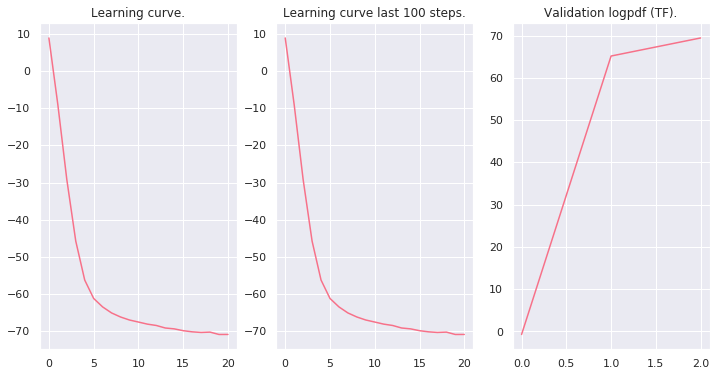

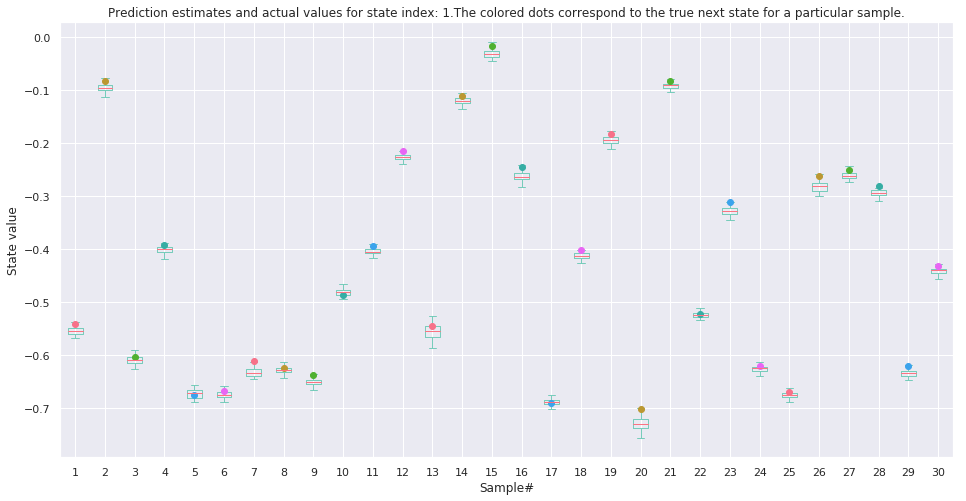

epoch: 40, loss: -73.3654


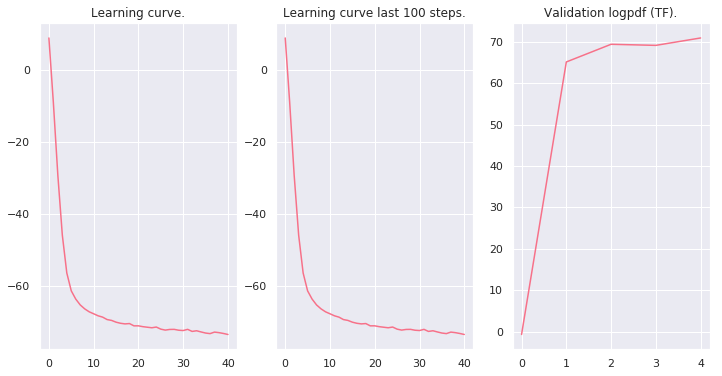

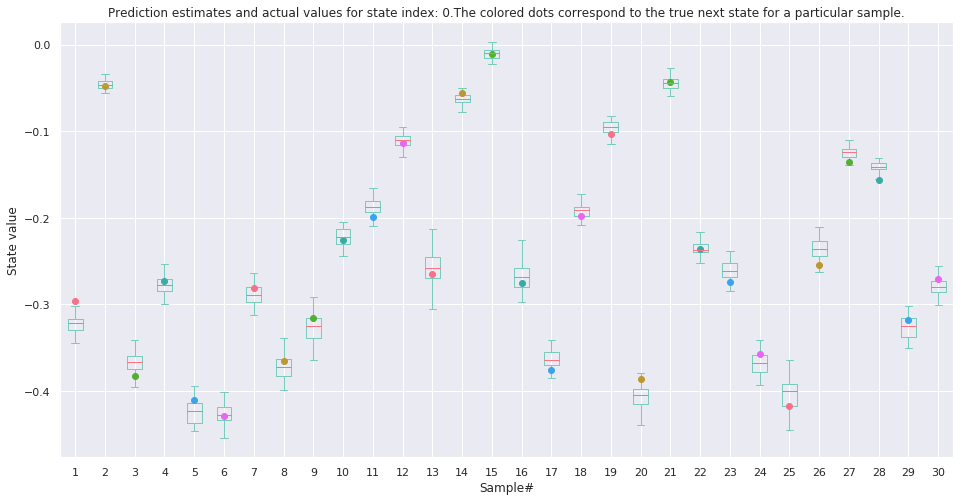

epoch: 60, loss: -74.2191


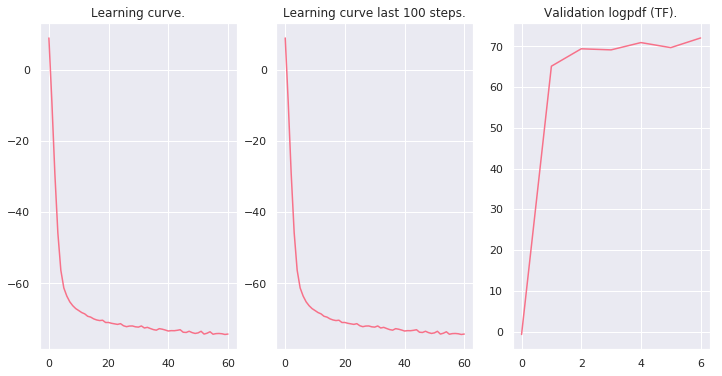

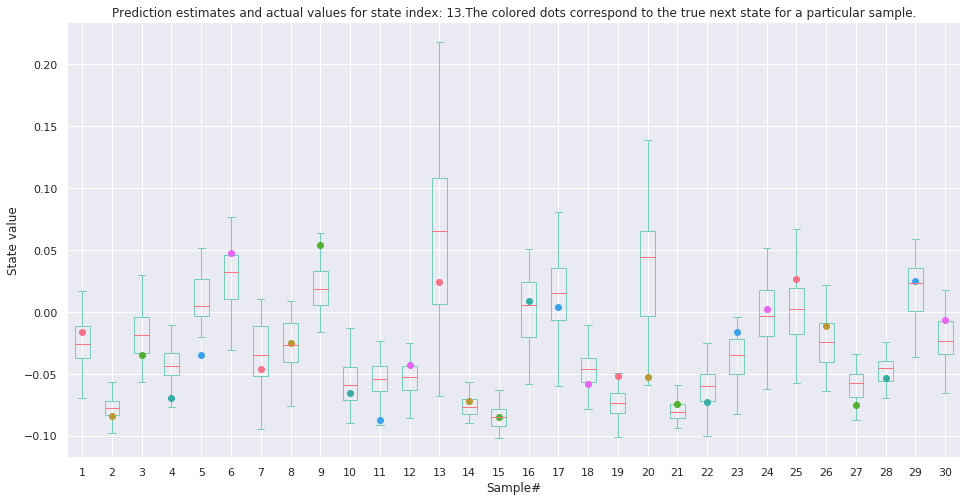

epoch: 80, loss: -75.5083


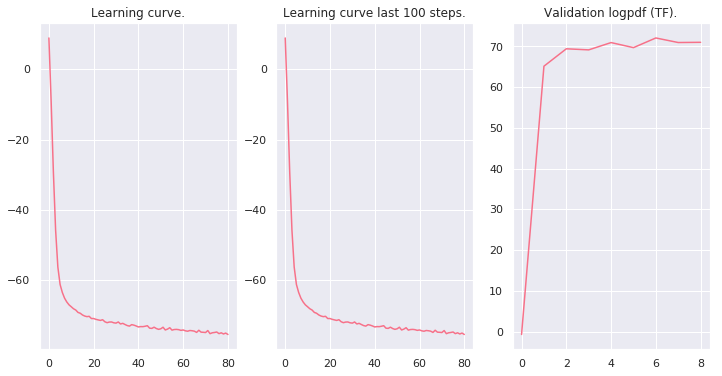

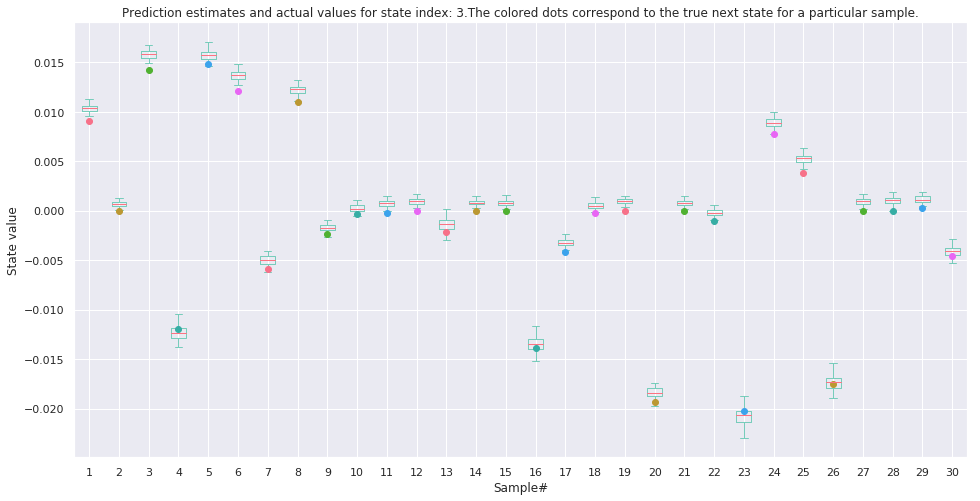

epoch: 100, loss: -76.1835


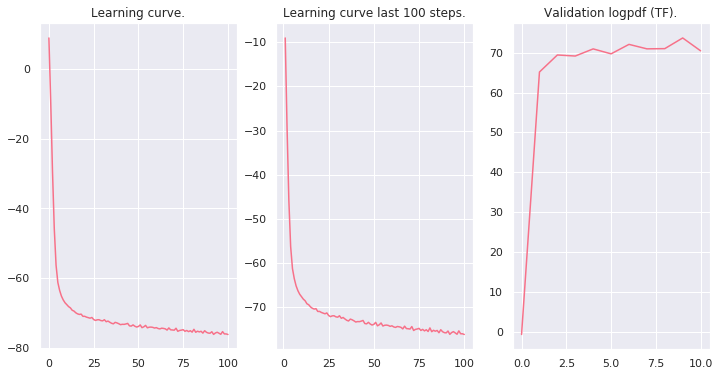

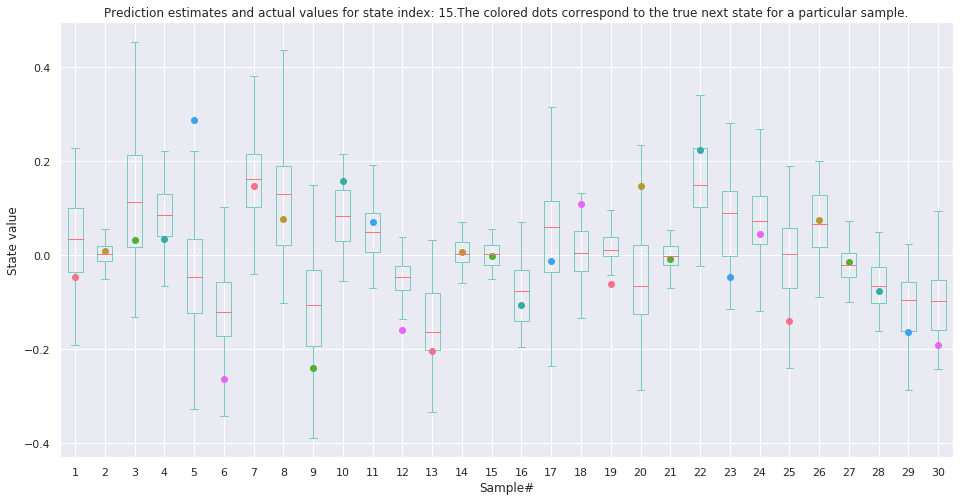

epoch: 120, loss: -76.7189


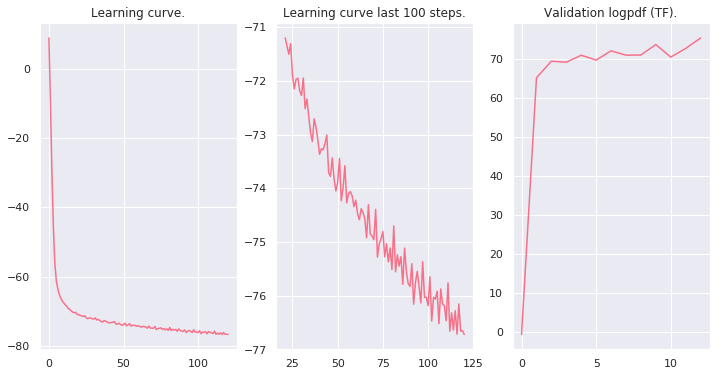

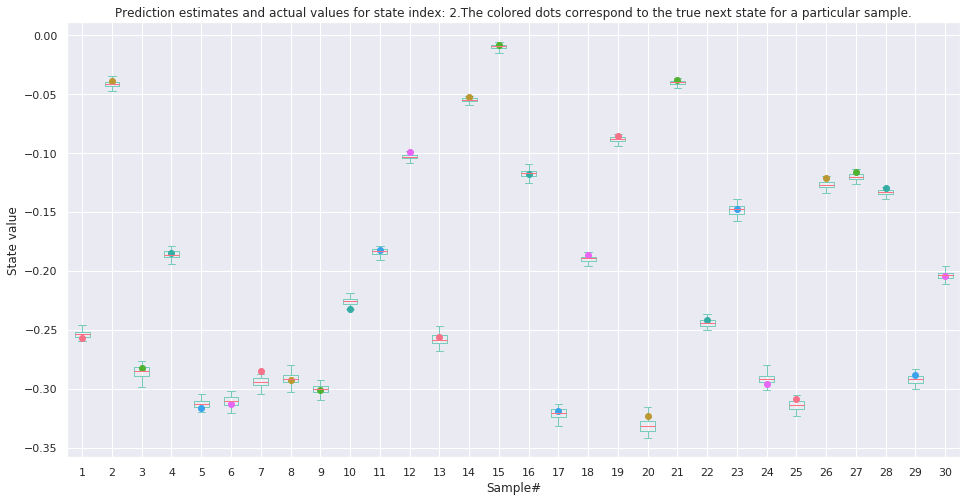

epoch: 140, loss: -77.3874


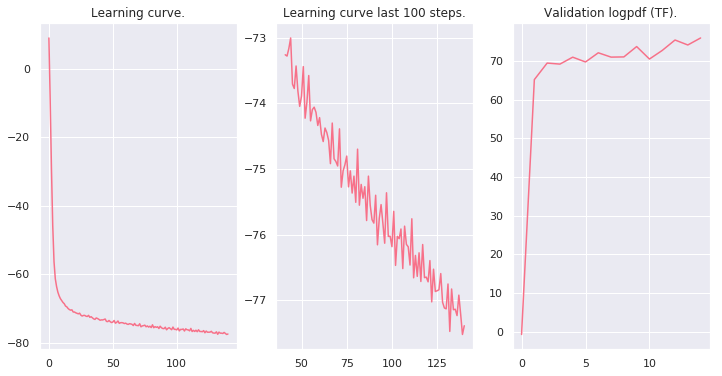

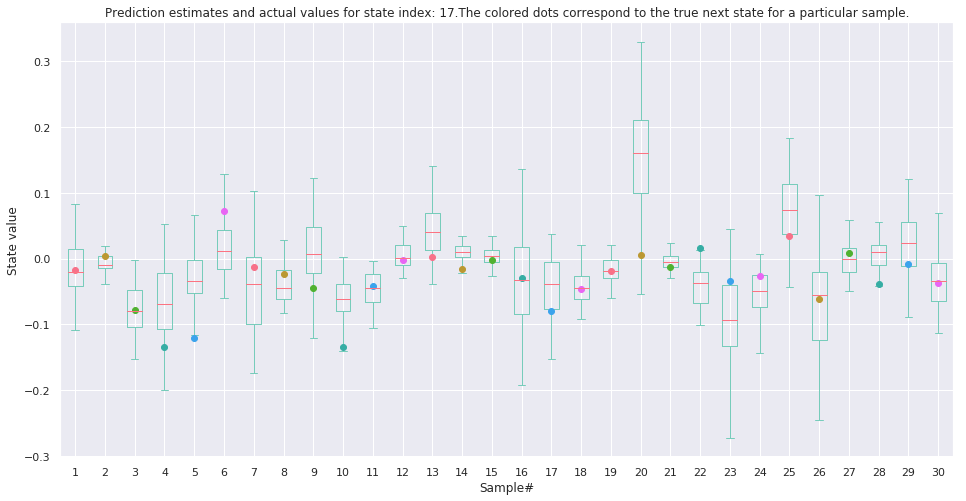

epoch: 160, loss: -78.3156


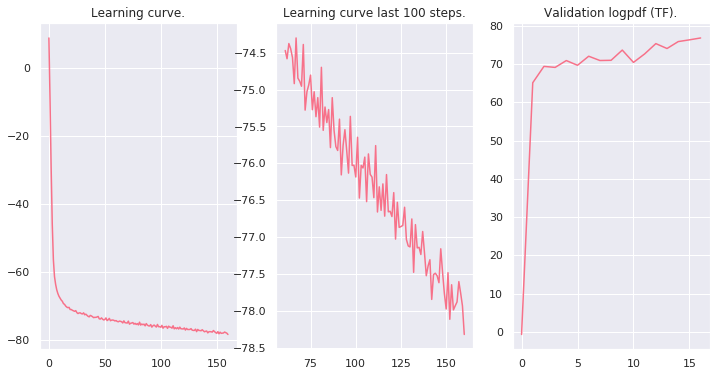

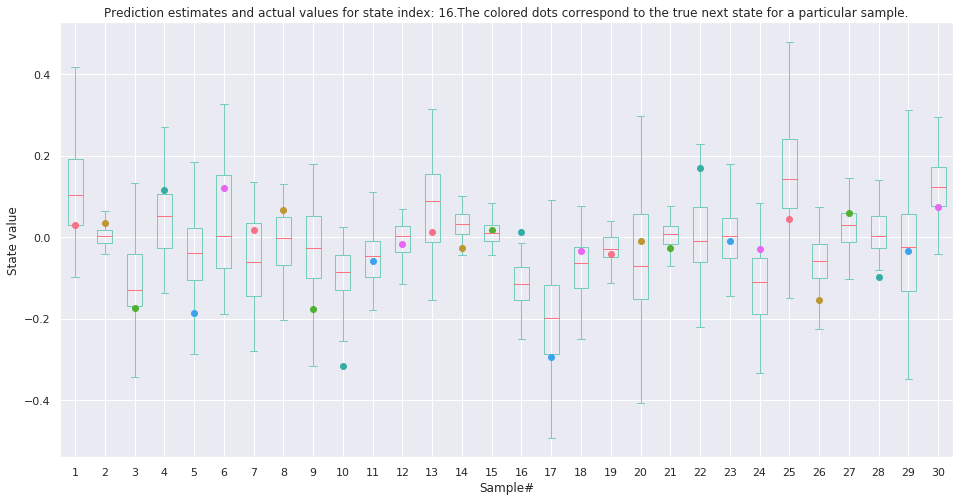

epoch: 180, loss: -78.9037


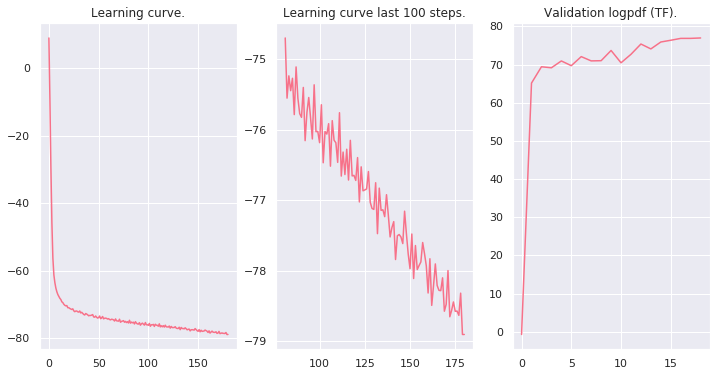

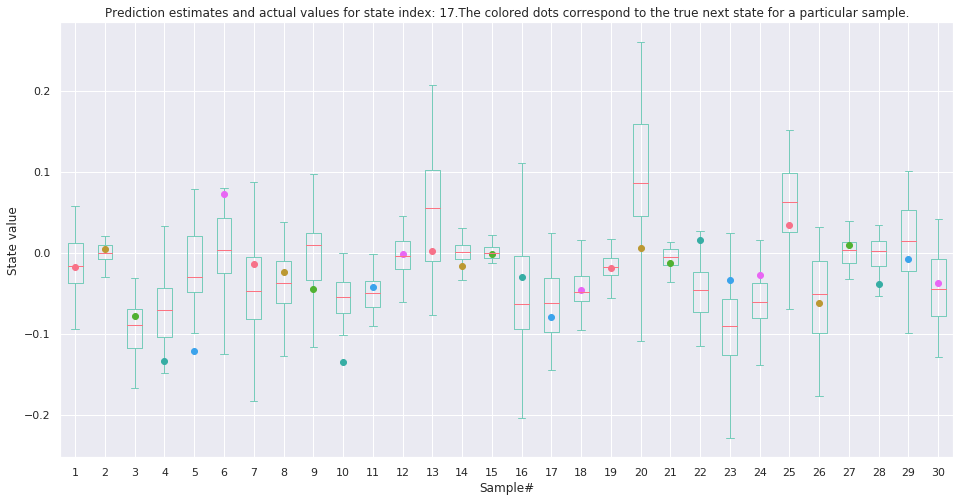

epoch: 200, loss: -79.6385


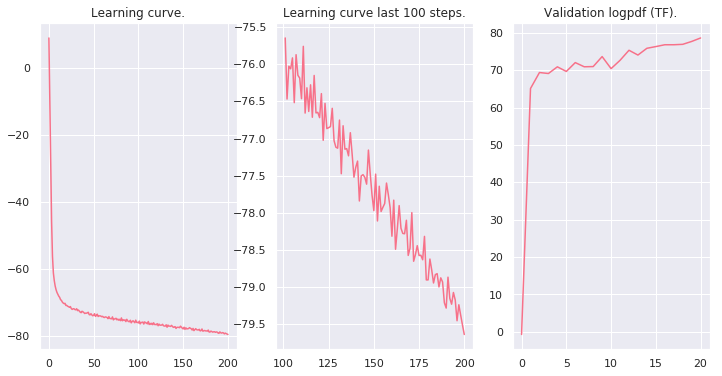

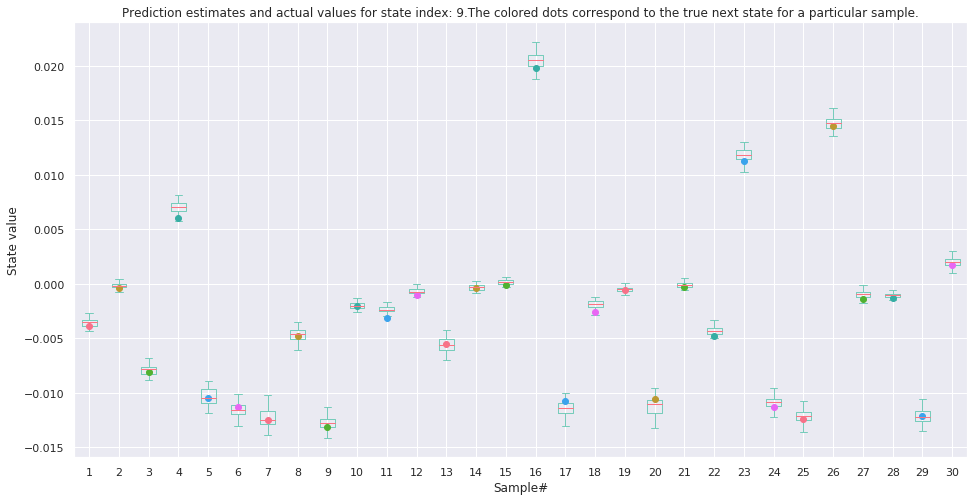

epoch: 220, loss: -80.3367


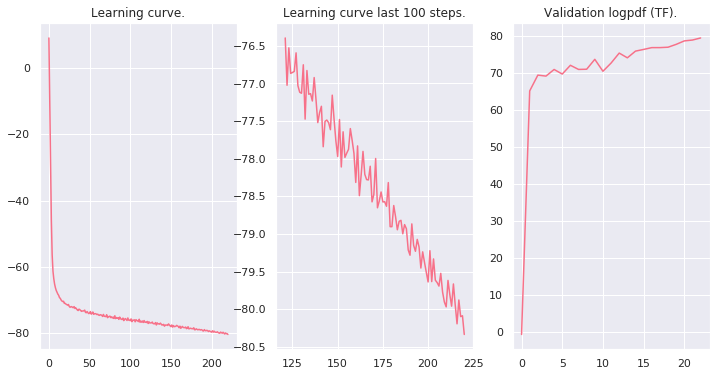

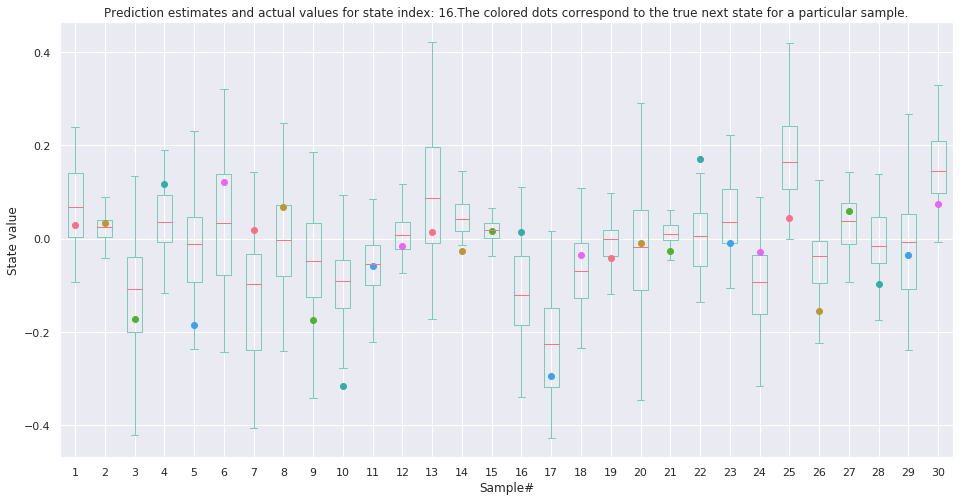

epoch: 240, loss: -80.9505


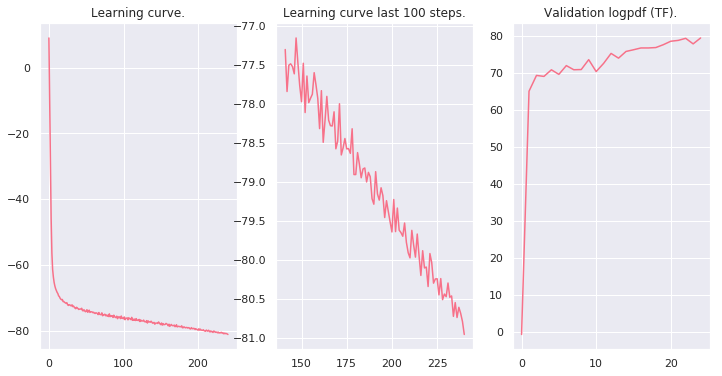

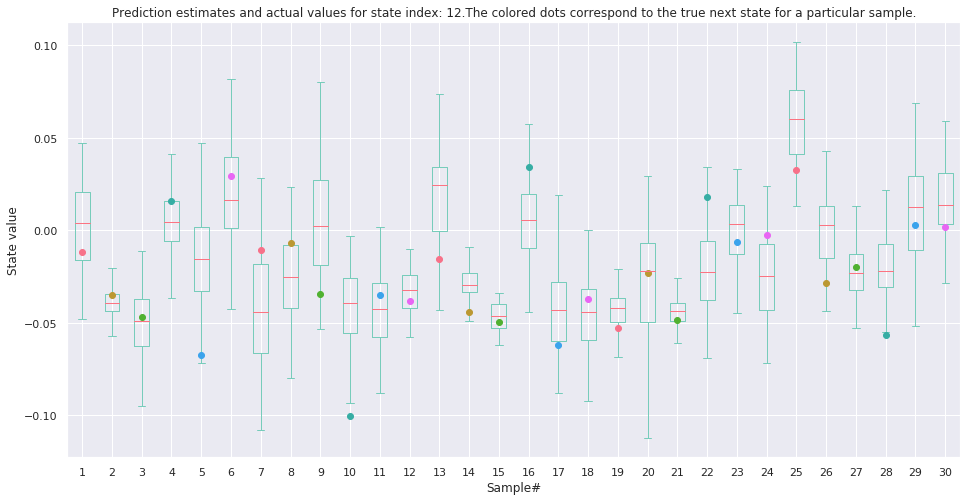

epoch: 260, loss: -81.3176


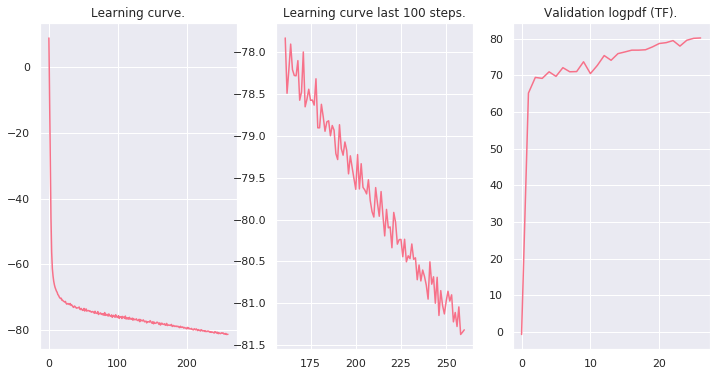

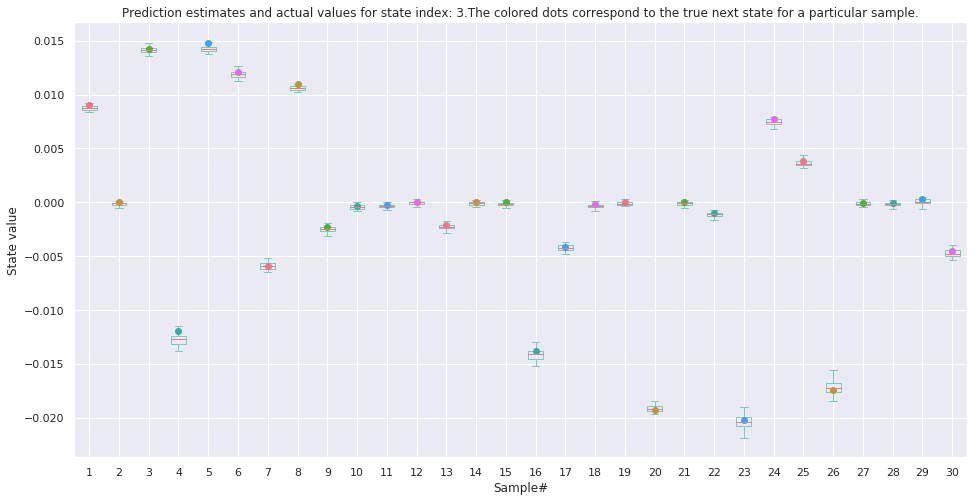

epoch: 280, loss: -81.9486


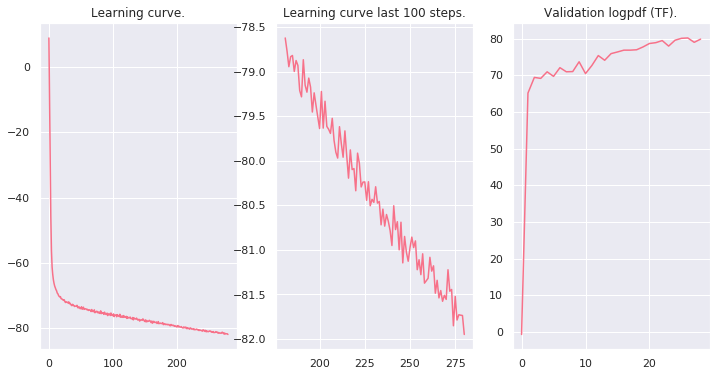

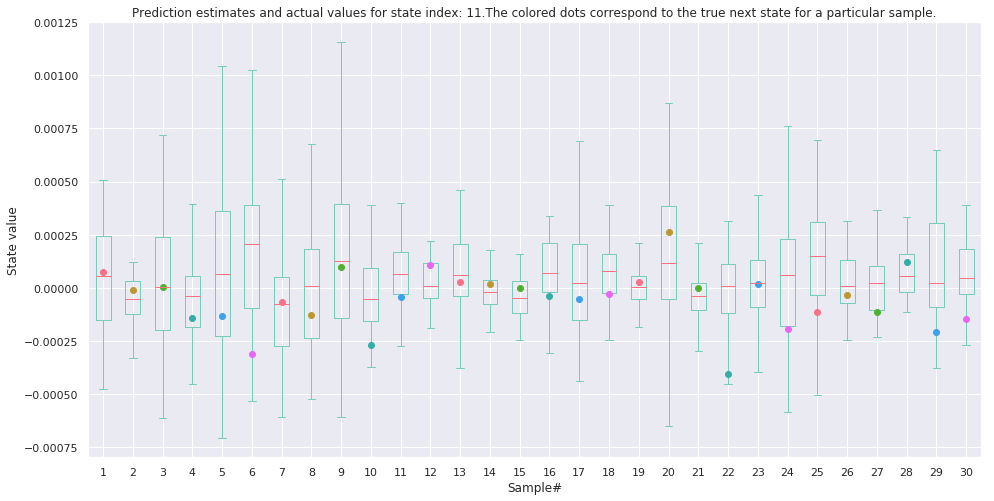

epoch: 300, loss: -81.9936


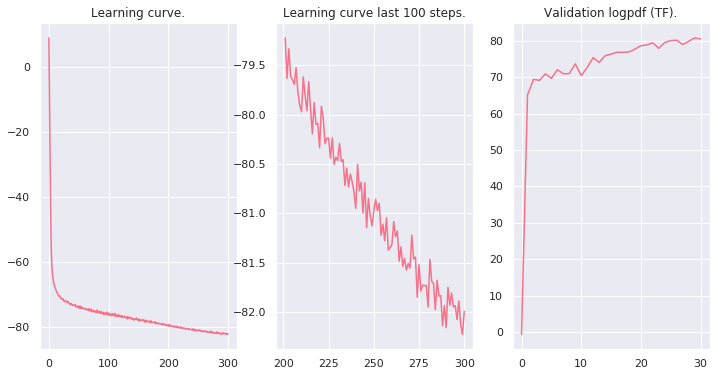

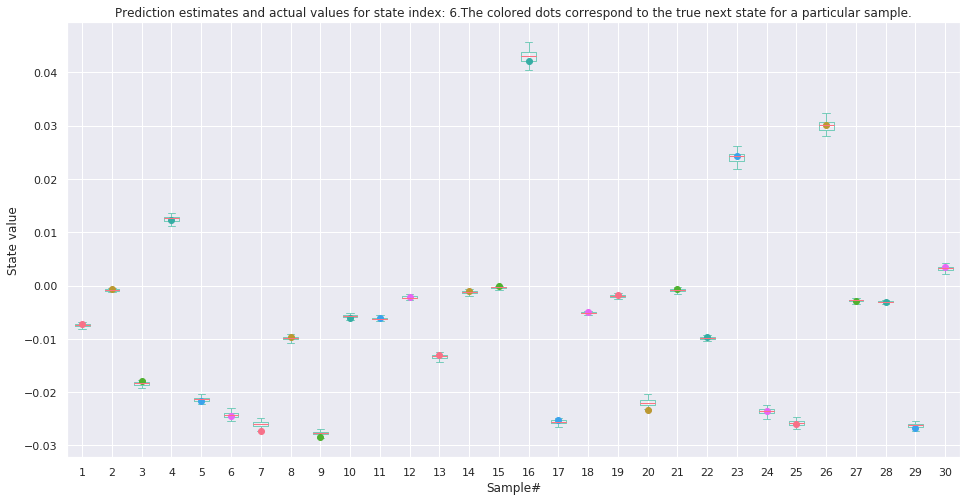

epoch: 320, loss: -82.5235


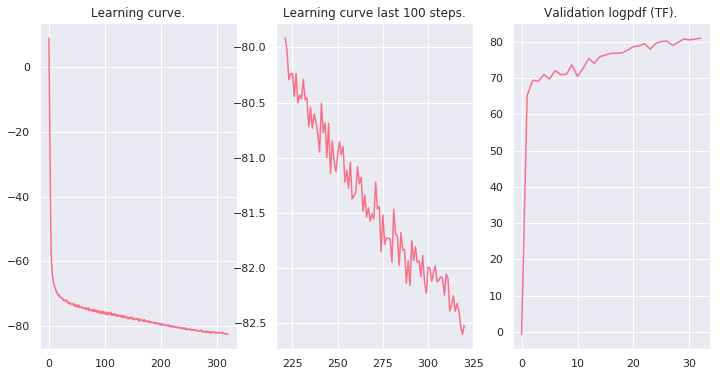

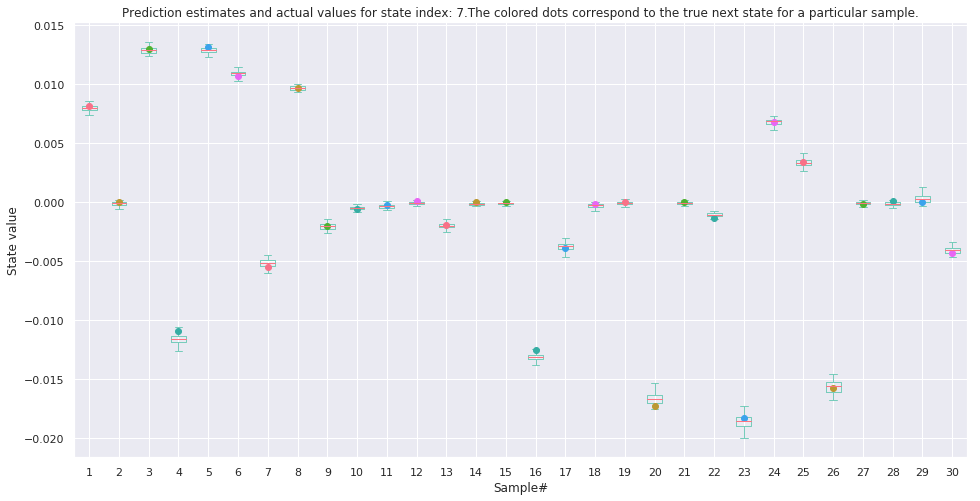

epoch: 340, loss: -83.0056


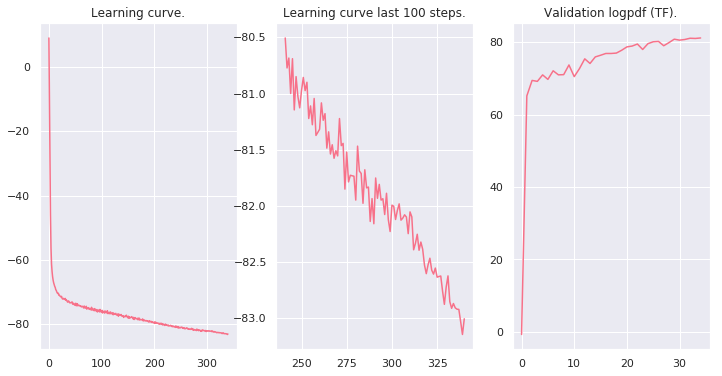

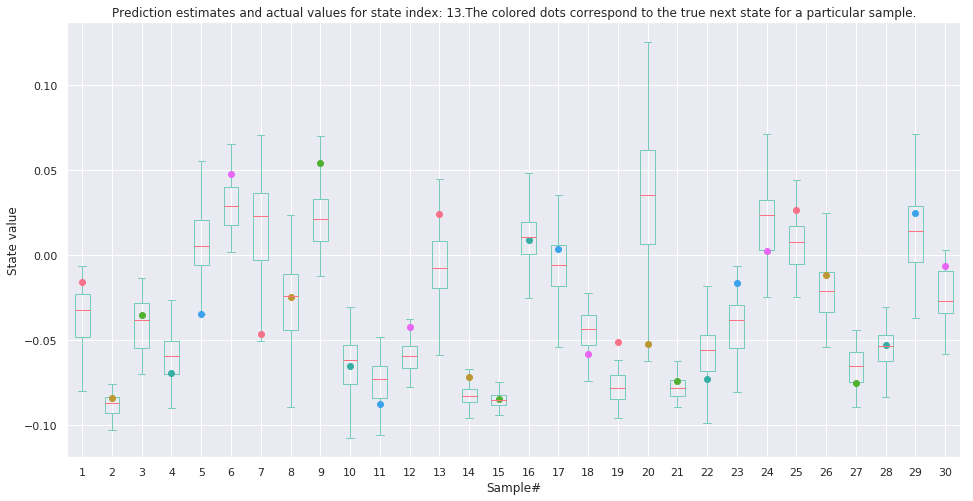

epoch: 360, loss: -83.4653


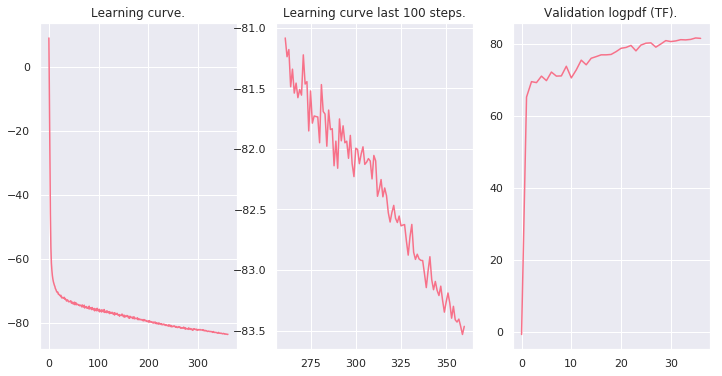

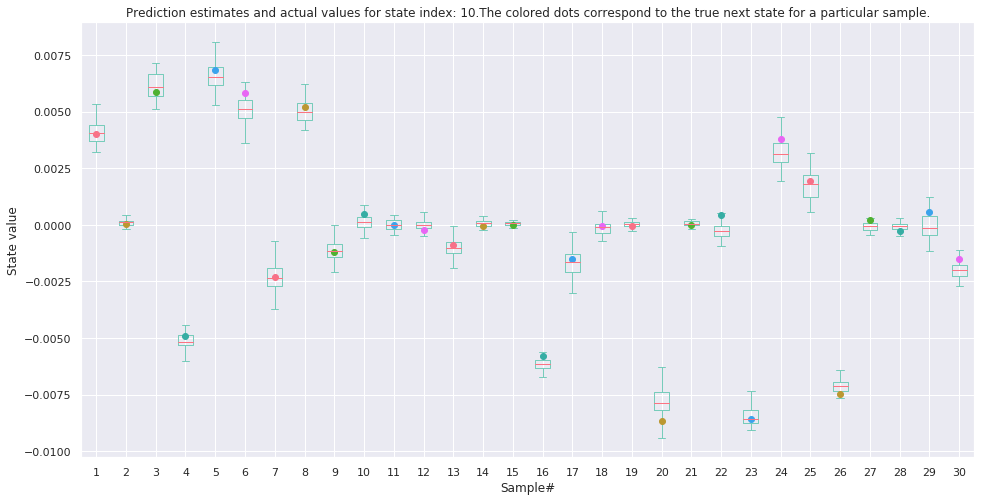

epoch: 380, loss: -83.8284


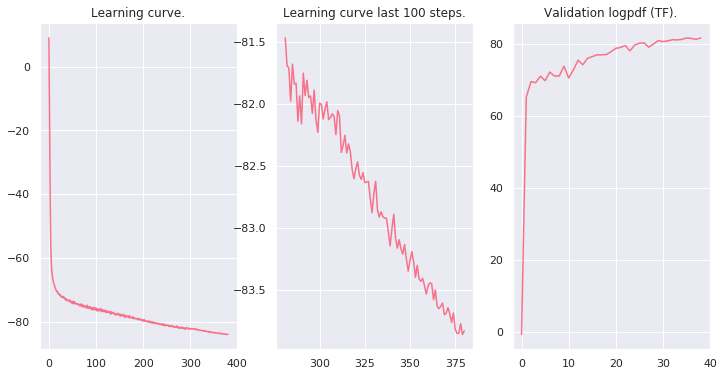

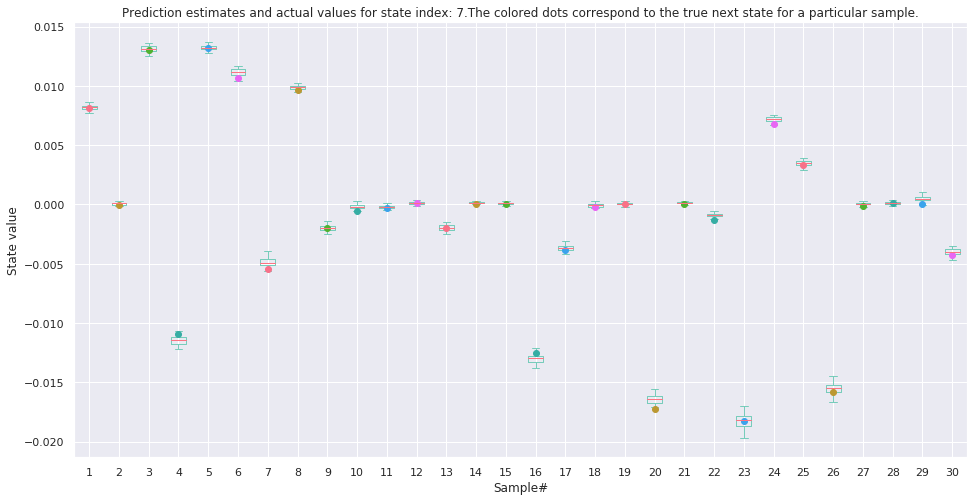

epoch: 400, loss: -84.2136


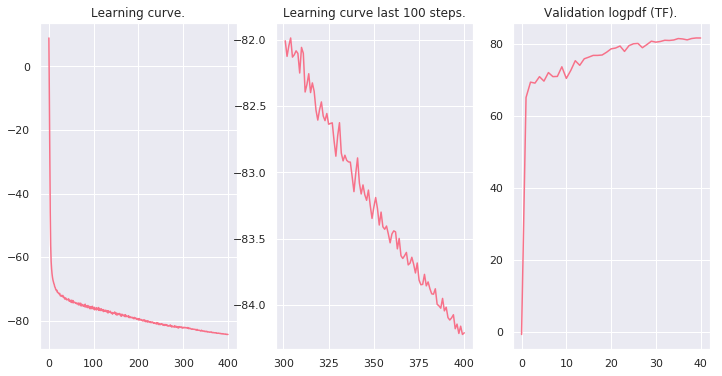

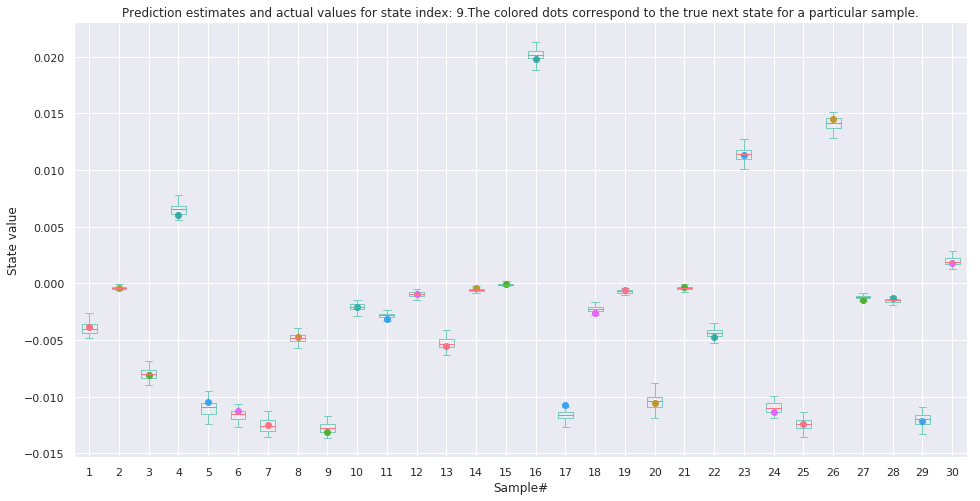

epoch: 420, loss: -84.6059


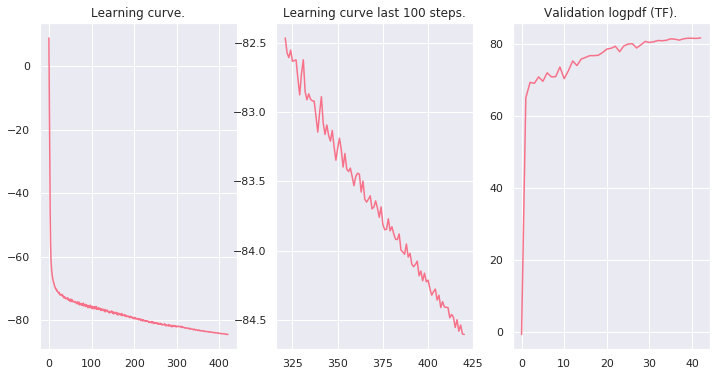

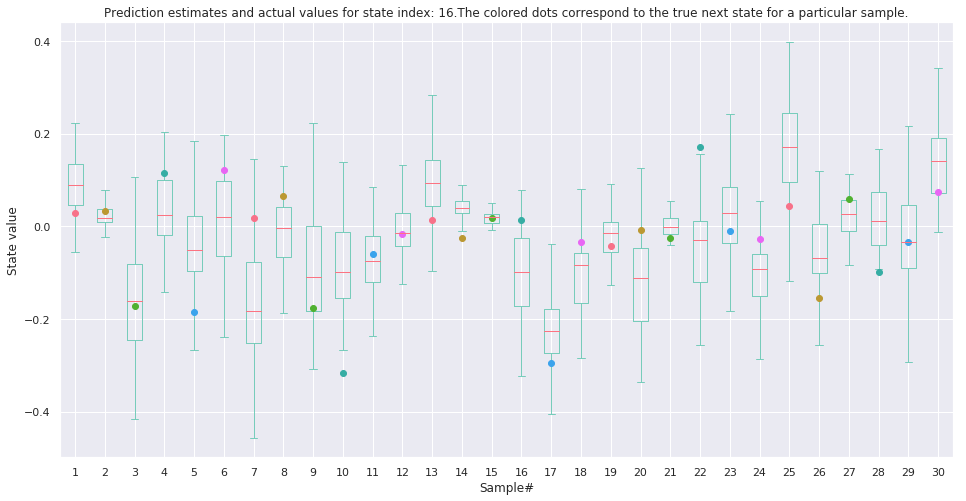

epoch: 440, loss: -84.8847


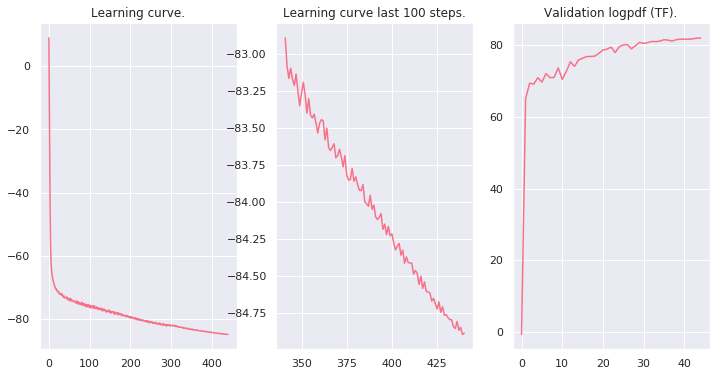

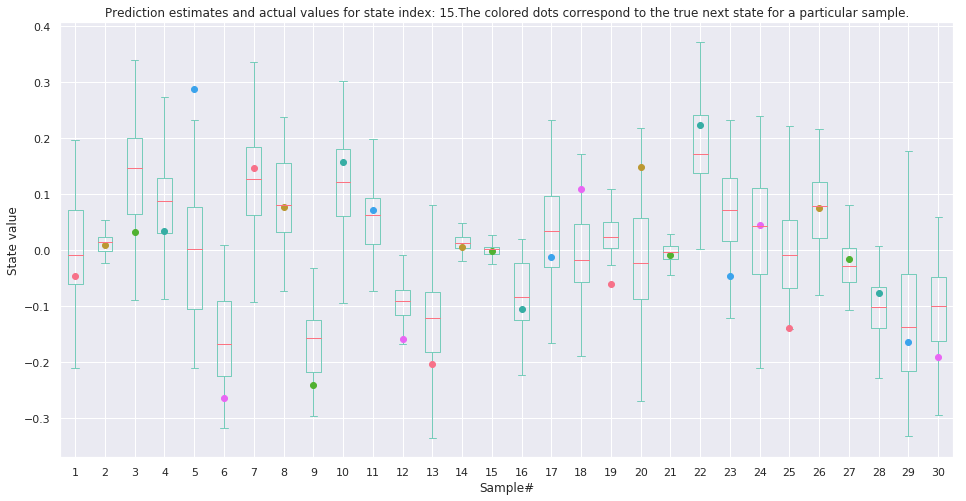

epoch: 460, loss: -85.0980


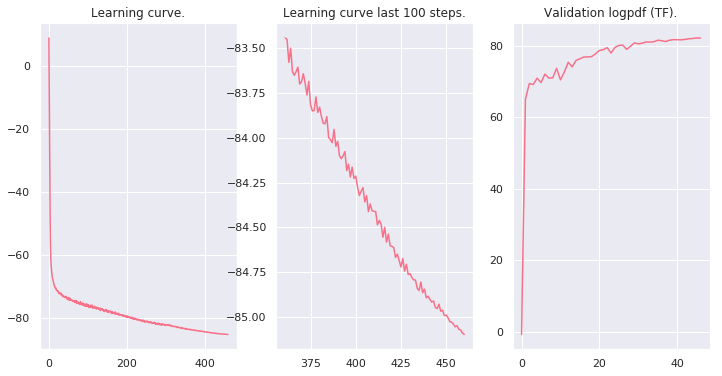

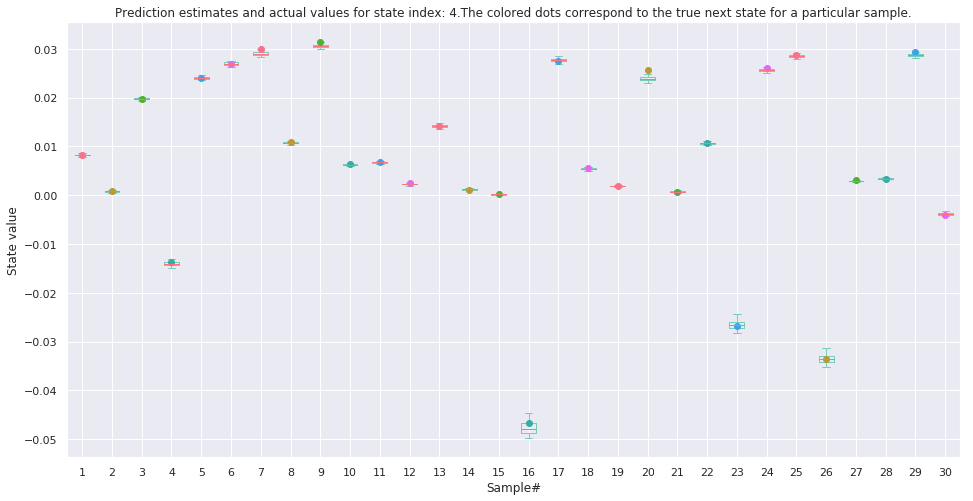

epoch: 480, loss: -85.2303


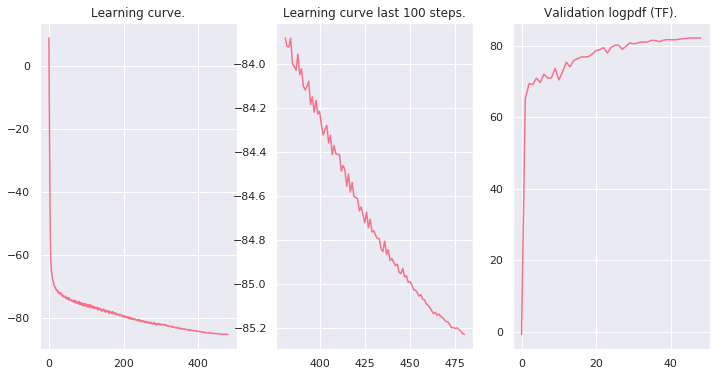

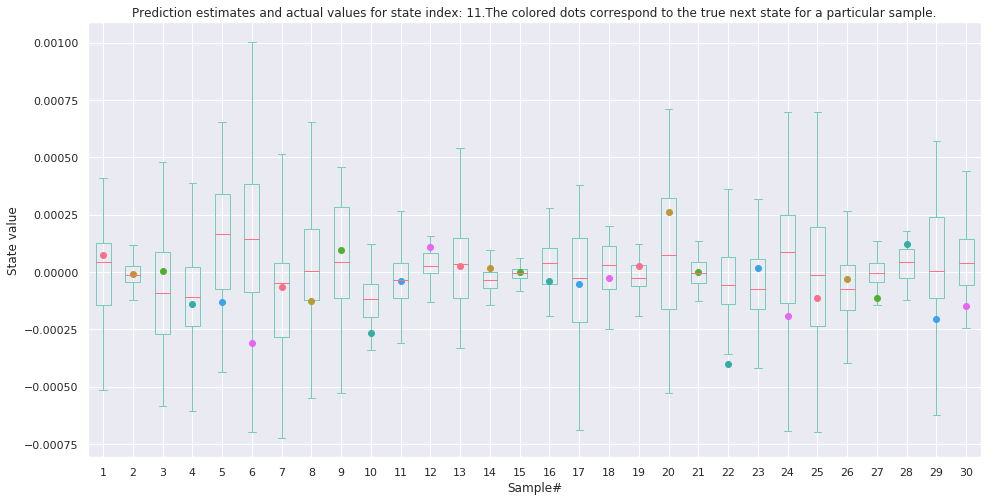

epoch: 499, loss: -85.2747


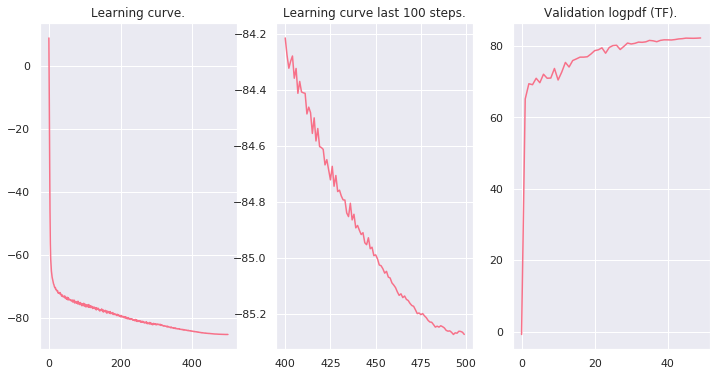

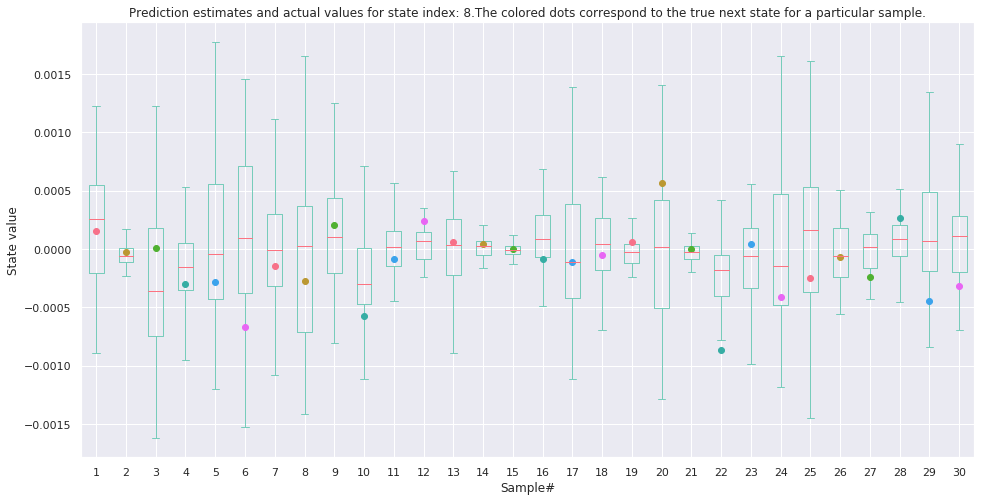

In [18]:
train_cvae(optimizer, loss, n_epochs_cvae, n_batches, n_trials, samples2plot)

In [19]:
get_results()

Results with prior: 82.24824


In [20]:
# for idx in range(n_states):
#     choice = np.random.choice(len(states_test), 20)
#     s = np.take(states_test, choice, axis=0)
#     ns = np.take(next_states_test, choice, axis=0)
#     sample_and_plot(cvae_samples, s, ns, n_trials=n_trials, state_idx=idx)

#     plt.show()

x = np.array([80.63891, 79.509514, 80.901215])
print('mean: ', x.mean())
print('std:', np.std(np.mean(x) - x))

mean:  80.34987966666665
std: 0.6038000875236395


In [21]:
if SIM:
    sess.run(init_test_op, {BATCH_SIZE: batch_size})
    train_cvae(optimizer, loss, n_epochs_cvae, n_batches, n_trials, samples2plot)

# Predictions

In [22]:
def get_posterior(posterior, states, next_states, mean=False):
    posterior_mean, posterior_std = sess.run([posterior.mean(), posterior.stddev()],
                                     feed_dict={X: states, Y: next_states})
    
    if mean:
        return np.mean(posterior_mean, axis=0), np.mean(posterior_std, axis=0)
    else:
        return posterior_mean, posterior_std

In [23]:
where = []
step = 100

with open('new-states-step{}.npz'.format(step), 'rb') as f:
    s = np.load(f)
    x = np.array([d[0] for d in s], dtype=np.float32)
    y = np.array([d[1] for d in s], dtype=np.float32)
    y =  y - x
    scale_deltas(y)
    
    print('y: ', y.shape)
    
    assert np.count_nonzero(x - x[0,:]) == 0

feed_dict = {X: x, Y: y}
#sess.run(init_test_op, {BATCH_SIZE: batch_size})
logprob = cvae.log_prob(Y)

results, cvae_data, all_mean, all_cov = sess.run([logprob, cvae.sample(),
                                               cvae.mean(), cvae.variance()], feed_dict)

mean = all_mean[0,:]
cov = all_cov[0,:]
# assert np.count_nonzero(all_mean - mean) == 0
# assert np.count_nonzero(all_cov - cov) == 0

ll_tf =  np.mean(results)
print('ll tf: ', ll_tf)

def ll_fn(x, mean, cov):
    lls = []
    for i in range(len(x)):
        lp = multivariate_normal.logpdf(x[i], mean, cov)
        lls.append(lp)
    return np.array(lls)

ll_sk = ll_fn(y, mean, cov)
ll_sk = np.mean(ll_sk)
print('ll sk: ', ll_sk)


def ll_per_dim_fn(x, mean, cov):
    ll_per_dim = np.empty((x.shape[-1]))
    for idx in range(x.shape[-1]):
        ll = ll_fn(x[:,idx], mean[idx], cov[idx])
        ll_per_dim[idx] = np.mean(ll)
    return np.array(ll_per_dim)


ll_per_dim = ll_per_dim_fn(y, mean, cov)
print('ll per dim mean: ', ll_per_dim.sum())

y:  (1000, 18)
ll tf:  81.885635
ll sk:  81.88186535126484
ll per dim mean:  81.88186535126485


In [24]:
def smpl_kl_func(x, mu, logvar):
    lls = ll_fn(x, mu, np.exp(logvar))
    hp = 0.5*np.log(2*np.pi*np.e*x.var())
    kl = - lls.mean() - hp
    assert kl > 0, 'woops'
    return kl

def kl_per_dim_fn(x, mean, cov):
    kl_per_dim = np.empty((x.shape[-1]))
    for idx in range(x.shape[-1]):
        ll = multivariate_normal.logpdf(x[:,idx], mean[idx], cov[idx])
        hp = 0.5*np.log(2*np.pi*np.e*x[:,idx].var())
        kl_per_dim[idx] = -np.mean(ll)-hp
    return kl_per_dim

kl_per_dim = kl_per_dim_fn(y, mean, cov)

print('KL per: ', kl_per_dim)

KL per:  [0.55885417 0.50553153 0.77913264 0.73863861 0.61944367 0.25555509
 0.13280411 0.41551675 0.57994062 0.49452512 0.45838274 0.54797881
 0.25814448 0.08672392 0.27425485 0.04046399 0.16415332 0.27454323]


d2s ll:  [5.16723534 5.06196292 4.4791989  7.45636989 6.85549011 6.42249861
 6.79612272 7.20732556 6.59066487 6.4549686  6.5873222  7.3694915
 1.95134341 2.35108071 1.81052308 0.79789902 0.40440372 1.47098538]
d2s kl:  [0.02984184 0.37016802 0.72515393 0.0712416  0.10214619 0.07269589
 0.05149401 0.09069157 0.3030169  0.14463498 0.19276968 0.28672533
 0.17812034 0.03079286 0.39809196 0.0682957  0.35583959 0.35984606]


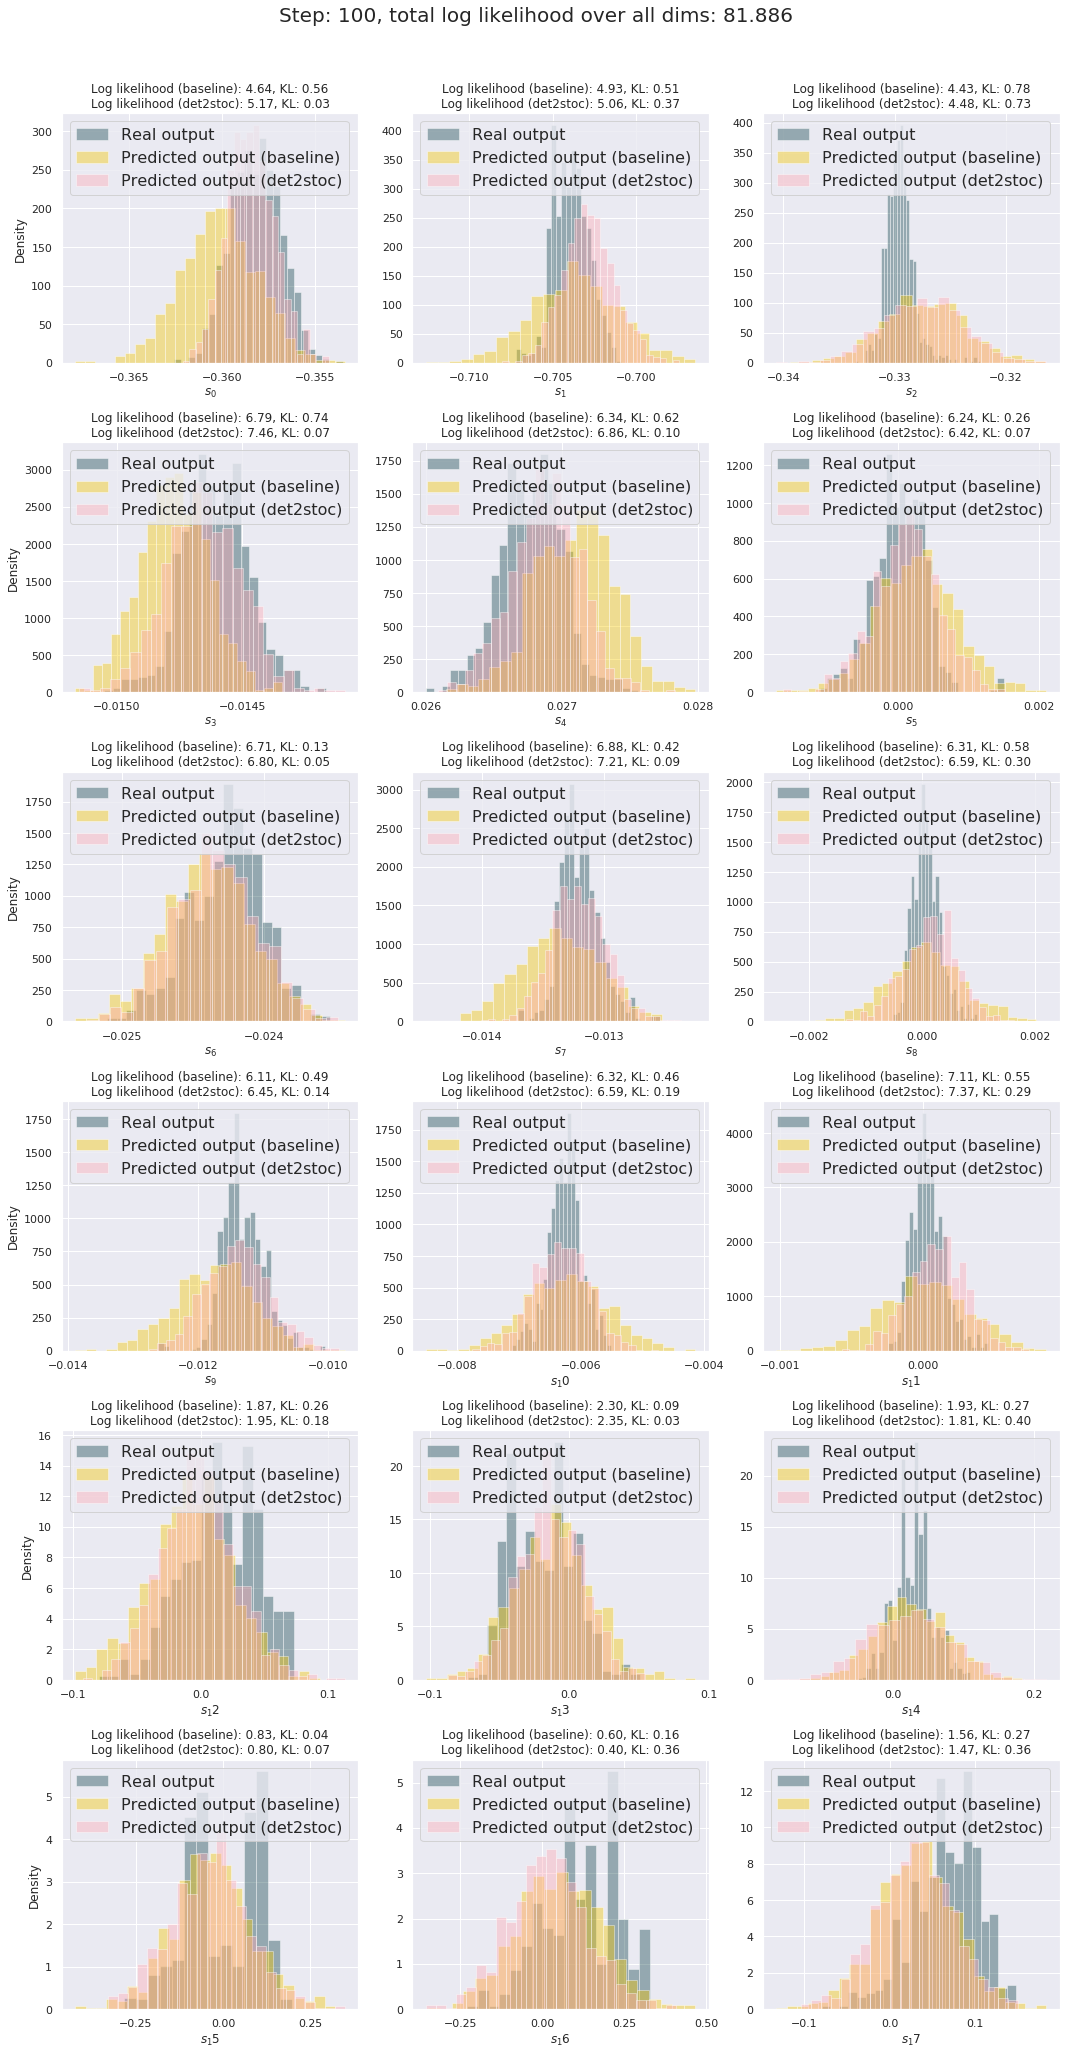

In [25]:
_, ax = plt.subplots(figsize=(15, 30))
nice = ['#ffa9b5', '#f6c800', '#757b33', '#15464e', '#cfebef', '#c3c1f2']
palette = sns.color_palette(nice)

with open('det2stoc_outputs_step{}.npz'.format(step), 'rb') as f:
    det2stoc_cvae_data = np.load(f)
    #d2s_ll_per_dim = ll_per_dim_fn(y, mean, cov)
    d2s_ll_per_dim = ll_per_dim_fn(y, np.mean(det2stoc_cvae_data, axis=0), np.var(det2stoc_cvae_data, axis=0))
    print('d2s ll: ', d2s_ll_per_dim)
    d2s_kl_per_dim = kl_per_dim_fn(y, np.mean(det2stoc_cvae_data, axis=0), np.var(det2stoc_cvae_data, axis=0))
    print('d2s kl: ', d2s_kl_per_dim)


with palette:

    for i in range(n_states):
        ax = plt.subplot(6, 3, i+1)
        plt.locator_params(axis='x', nbins=4)
        sns.distplot(y[...,i], kde=False, norm_hist=True, label='Real output', color=palette[3])
        sns.distplot(cvae_data[...,i], kde=False, norm_hist=True, label='Predicted output (baseline)', color=palette[1])
        sns.distplot(det2stoc_cvae_data[...,i], kde=False, norm_hist=True, label='Predicted output (det2stoc)', color=palette[0])
        title_template = 'Log likelihood (baseline): {:.2f}, KL: {:.2f}\nLog likelihood (det2stoc): {:.2f}, KL: {:.2f}'
        ax.set_title(title_template.format(
                         ll_per_dim[i], kl_per_dim[i], d2s_ll_per_dim[i], d2s_kl_per_dim[i]))
        ax.set_xlabel('$s_{}$'.format(i))
        if i % 3 == 0:
            ax.set_ylabel('Density')
        ax.legend(prop={'size': 16}, loc='upper left')

plt.suptitle('Step: {}, total log likelihood over all dims: {:.3f}'.format(step, ll_tf), fontsize=20)
plt.tight_layout(w_pad=0, h_pad=1, rect=[0, 0.03, 1, 0.95])

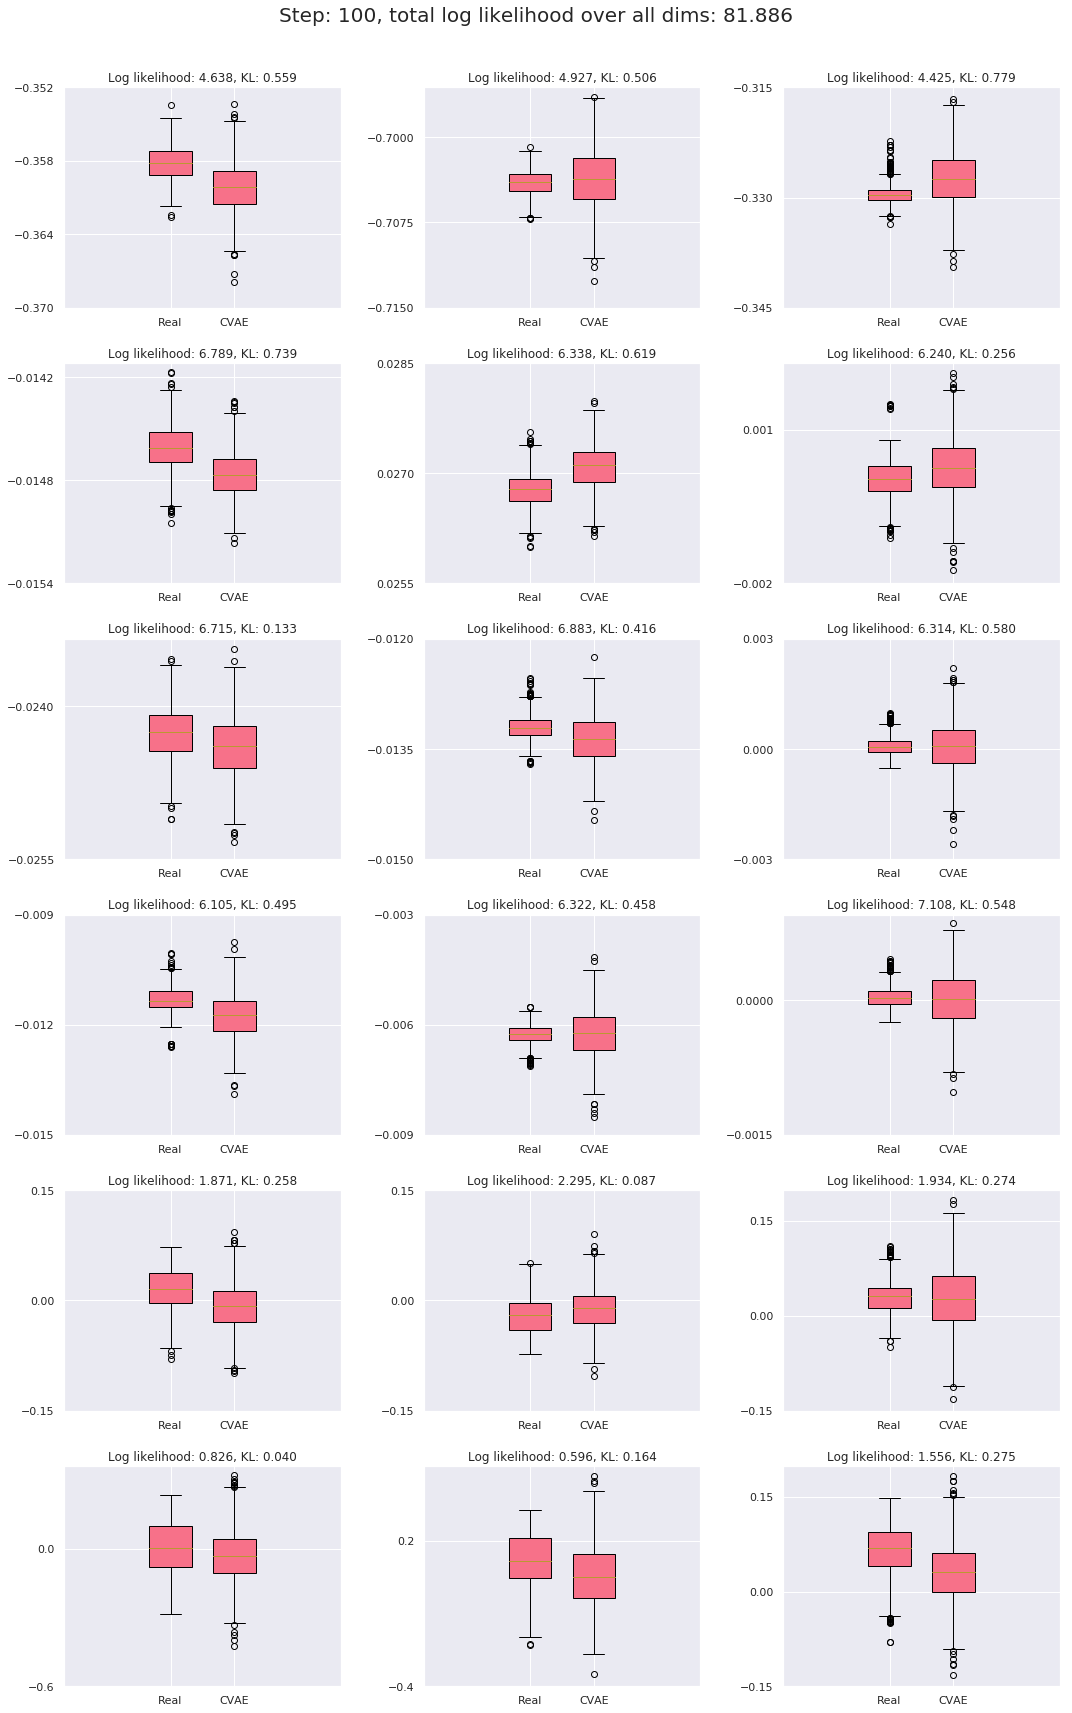

In [26]:
fig = plt.figure(figsize=(15,25))
n_states = y.shape[-1]

palette = sns.color_palette('Set2', 10)

vert = True
idx = 0
for row in range(n_states):
    ax = plt.subplot(6,3,row+1)
    
    datai = y[np.newaxis,:,row]
    cvae_datai = cvae_data[np.newaxis,:,row]
    
    d = np.vstack([datai, cvae_datai]).T
    ax.boxplot(d,
               vert=vert,
               widths = [.2, 0.2],
               manage_xticks=True,
               patch_artist=True, 
               showfliers=True, # This would show outliers (the remaining .7% of the data)
               positions = [-0.15, 0.15],
#                boxprops = dict(linestyle='--', linewidth=3, color='Black', facecolor = palette[0], alpha = 0.5),
#                medianprops = dict(linestyle='-', linewidth=3, color=palette[1]),
#                whiskerprops = dict(linestyle='-', linewidth=3, color='Black', alpha = .4),
#                capprops = dict(linestyle='-', linewidth=2, color='Black', alpha=0.5),
#                flierprops = dict(marker='o', markerfacecolor=palette[3], markeredgecolor='none', markersize=5,
#                   linestyle='none', alpha = .4),
               labels=['Real', 'CVAE']
              )
    ax.set_title('Log likelihood: {:.3f}, KL: {:.3f}'.format(ll_per_dim[row], kl_per_dim[row]))
    ax.set_xticks([-0.15, 0.15])
    ax.set_xticklabels(['Real', 'CVAE'])
    ax.set_yticks(ax.get_yticks()[::3])

plt.suptitle('Step: {}, total log likelihood over all dims: {:.3f}'.format(step, ll_tf), fontsize=20)
plt.tight_layout(w_pad=2, h_pad=2, rect=[0, 0.03, 1, 0.95])
#plt.show()